In [ ]:
import urllib.request
from pathlib import Path
import os
import pandas as pd
import numpy as np
path = Path()

# Dictionary of file names and download links
files = {'PEP.csv':'https://query1.finance.yahoo.com/v7/finance/download/PEP?period1=1501718400&period2=1627948800&interval=1d&events=history&includeAdjustedClose=true',
         'KO.csv':'https://query1.finance.yahoo.com/v7/finance/download/KO?period1=1501718400&period2=1627948800&interval=1d&events=history&includeAdjustedClose=true',
          'USDX.csv':'https://query1.finance.yahoo.com/v7/finance/download/DX-Y.NYB?period1=1501718400&period2=1627948800&interval=1d&events=history&includeAdjustedClose=true'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
      urllib.request.urlretrieve(url,filename)

In [ ]:
# Read in file and clean the data
pep_df = pd.read_csv('PEP.csv')
ko_df = pd.read_csv('KO.csv')
usdx_df = pd.read_csv('USDX.csv')

usdx_df_clear = usdx_df.dropna()
date = usdx_df_clear['Date'].tolist()
for day in ko_df['Date']:
  if day not in date:
    ko_df.drop(ko_df[ko_df['Date']==day].index, inplace=True)
    pep_df.drop(pep_df[pep_df['Date']==day].index, inplace=True)
pep_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-03,115.730003,116.660004,115.680000,116.300003,103.174911,2986200
1,2017-08-04,116.320000,116.489998,115.870003,116.370003,103.237015,2955200
2,2017-08-07,116.449997,117.220001,116.379997,116.959999,103.760414,2569600
3,2017-08-08,116.800003,116.949997,116.370003,116.709999,103.538635,2412600
4,2017-08-09,116.489998,116.699997,115.959999,116.629997,103.467659,2513800
...,...,...,...,...,...,...,...
1001,2021-07-27,157.309998,158.660004,157.029999,157.940002,157.940002,4043900
1002,2021-07-28,157.600006,157.960007,155.910004,156.490005,156.490005,3556800
1003,2021-07-29,157.229996,157.429993,156.199997,156.809998,156.809998,3055600
1004,2021-07-30,157.369995,157.600006,156.619995,156.949997,156.949997,3757300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


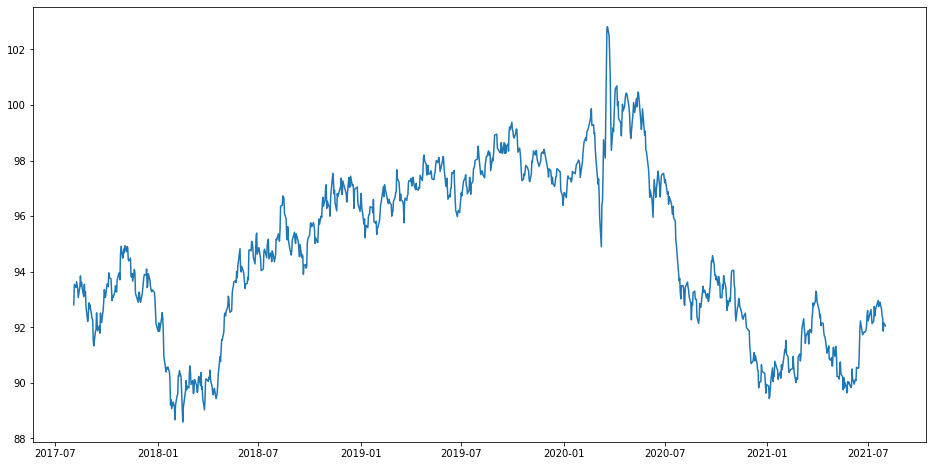

In [ ]:
import matplotlib.pyplot as plt
#setting index as date
pep_df['Date'] = pd.to_datetime(pep_df.Date,format='%Y-%m-%d')
pep_df.index = pep_df['Date']
ko_df['Date'] = pd.to_datetime(ko_df.Date,format='%Y-%m-%d')
ko_df.index = ko_df['Date']
usdx_df_clear['Date'] = pd.to_datetime(usdx_df_clear.Date,format='%Y-%m-%d')
usdx_df_clear.index = usdx_df_clear['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(usdx_df_clear['Close'], label='Close Price history')

In [ ]:
pep_df = pep_df.loc[:,['Date','Close']]
pep_df_rename = pep_df.rename(columns={'Close':'PEP_Close','Date':'date'})

ko_df = ko_df.loc[:,['Date','Close']]
ko_df_rename = ko_df.rename(columns={'Close':'KO_Close','Date':'date'})

usdx_df_clear = usdx_df_clear.loc[:,['Date','Close']]
usdx_df_rename = usdx_df_clear.rename(columns={'Close':'USDX_Close','Date':'date'})

data = pep_df_rename.merge(ko_df_rename,how='left',on=['date'])
data = data.merge(usdx_df_rename,how='left',on=['date'])
data.index = data['date']
data.head()

,date,PEP_Close,KO_Close,USDX_Close
date,,,,
2017-08-03,2017-08-03,116.300003,45.669998,92.809998
2017-08-04,2017-08-04,116.370003,45.500000,93.540001
2017-08-07,2017-08-07,116.959999,45.639999,93.430000
2017-08-08,2017-08-08,116.709999,45.599998,93.639999
2017-08-09,2017-08-09,116.629997,45.590000,93.519997


In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(pep_df)),columns=['Date', 'PEP_Close', 'KO_Close', 'USDX_Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['date'][i]
    new_data['PEP_Close'][i] = data['PEP_Close'][i]
    new_data['KO_Close'][i] = data['KO_Close'][i]
    new_data['USDX_Close'][i] = data['USDX_Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

bound = dataset.shape[0]*0.8
bound = round(bound)

train = dataset[0:bound,:]
valid = dataset[bound:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)



In [ ]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,:])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],3)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

738/738 - 20s - loss: 0.0068


In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,3)
inputs = scaler.transform(inputs)
inputs.shape


(259, 3)

In [ ]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,:])
X_test = np.array(X_test)

In [ ]:
closing_price = model.predict(X_test)
b = np.append(closing_price,np.zeros([len(closing_price),2]),1)
closing_price = scaler.inverse_transform(b)
closing_price = closing_price[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Mean Square Error:14.481062137982185


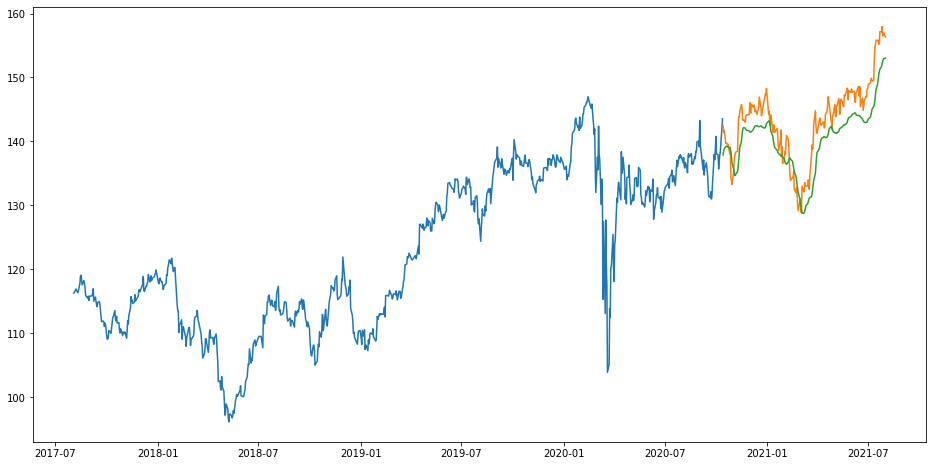

In [ ]:
#for plotting
train = new_data[:bound]
valid = new_data[bound:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['PEP_Close'])
plt.plot(valid[['PEP_Close','Predictions']])

from sklearn.metrics import mean_squared_error
y_test = valid['PEP_Close']
df = pd.DataFrame(closing_price)
last_column = df.iloc[: , -1]
last_column.round(0).astype(int)
mse = mean_squared_error(y_test.reset_index(drop=True),last_column.reset_index(drop=True))
print("Mean Square Error:" + str(mse))